In [1]:
import pandas as pd
import os
import numpy as np

# testing out langchain tools
from langchain.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_core.prompts import ChatPromptTemplate
# import llama-7b
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from operator import itemgetter

# load llama, make sure it's running locally or change the model to the one you want to use
llm = ChatOllama(model="llama2")

base_dir = os.path.dirname(os.getcwd())
data_limit = 100_000

In [2]:
rosters = pd.read_csv(os.path.join(base_dir, 'nfl_data', 'rosters.csv')).head(data_limit)
stats = pd.read_csv(os.path.join(base_dir, 'nfl_data', 'stats.csv')).head(data_limit)

/var/folders/7q/jspctqnn1_z3f1xv9fn73rt40000gn/T/ipykernel_6155/1360184311.py:1: DtypeWarning: Columns (4,5,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  rosters = pd.read_csv(os.path.join(base_dir, 'nfl_data', 'rosters.csv')).head(data_limit)


In [3]:
print(rosters.columns)
rosters.describe()

Index(['Unnamed: 0', 'season', 'team', 'position', 'depth_chart_position',
       'jersey_number', 'status', 'player_name', 'first_name', 'last_name',
       'birth_date', 'height', 'weight', 'college', 'player_id', 'espn_id',
       'sportradar_id', 'yahoo_id', 'rotowire_id', 'pff_id', 'pfr_id',
       'fantasy_data_id', 'sleeper_id', 'years_exp', 'headshot_url',
       'ngs_position', 'week', 'game_type', 'status_description_abbr',
       'football_name', 'esb_id', 'gsis_it_id', 'smart_id', 'entry_year',
       'rookie_year', 'draft_club', 'draft_number', 'age'],
      dtype='object')


,Unnamed: 0,season,height,weight,espn_id,yahoo_id,rotowire_id,pff_id,fantasy_data_id,sleeper_id,years_exp,week,gsis_it_id,entry_year,rookie_year,draft_number,age
count,100000.000000,100000.000000,99998.000000,99998.000000,19371.000000,12431.000000,19418.000000,19408.000000,13716.00000,13770.000000,100000.000000,100000.000000,23404.000000,100000.000000,100000.000000,75267.000000,78669.000000
mean,15145.408910,2009.107270,73.950799,247.034011,9112.694337,16625.940069,4827.701772,3281.899784,6858.15697,374.341830,4.211280,9.483670,32047.985643,2004.895990,2004.899320,100.984097,27.413408
std,9371.490888,0.908081,2.569649,45.527339,3526.179198,78511.371646,1527.540500,1600.574155,3633.69820,620.939109,3.597381,5.219455,2648.173461,3.578458,3.579376,71.757098,3.643838
min,0.000000,2008.000000,66.000000,150.000000,1097.000000,3727.000000,395.000000,226.000000,3.00000,4.000000,0.000000,1.000000,21213.000000,1972.000000,1972.000000,1.000000,20.849000
25%,6639.000000,2008.000000,72.000000,208.000000,5713.000000,7321.000000,3949.000000,1840.000000,3942.00000,148.000000,1.000000,5.000000,30311.000000,2003.000000,2003.000000,38.000000,24.556000
50%,14972.500000,2009.000000,74.000000,240.000000,10462.000000,8409.000000,5253.000000,3623.000000,7203.00000,287.000000,3.000000,9.000000,32375.000000,2006.000000,2006.000000,90.000000,26.661000
75%,23306.000000,2010.000000,76.000000,290.000000,11443.000000,9271.000000,5874.000000,4519.000000,9739.00000,487.000000,6.000000,14.000000,34467.000000,2008.000000,2008.000000,155.000000,29.763000
max,31925.000000,2011.000000,81.000000,382.000000,13939.000000,900039.000000,7975.000000,6118.000000,14710.00000,8079.000000,38.000000,21.000000,36712.000000,2010.000000,2010.000000,329.000000,46.472000


In [4]:
print(stats.columns)
stats.describe()

Index(['Unnamed: 0', 'player_id', 'player_name', 'player_display_name',
       'position', 'position_group', 'headshot_url', 'recent_team', 'season',
       'week', 'season_type', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr',
       'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'racr', 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds',
       'fantasy_points', 

,Unnamed: 0,season,week,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
count,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,...,79720.00000,64146.000000,79720.000000,64146.000000,64146.000000,64146.000000,64146.000000,79720.000000,79720.000000,79720.000000
mean,2660.269167,2015.117812,9.561540,2.186653,3.495547,24.934420,0.153901,0.088823,0.233756,1.536829,...,1.20715,0.783052,0.005946,0.872270,0.126025,0.126025,0.277255,0.005519,6.483463,8.670116
std,1540.105341,4.320615,5.324637,6.676154,10.535155,76.834607,0.581138,0.399796,0.864066,5.947242,...,1.56231,3.364091,0.077368,4.832175,0.090596,0.157296,0.227305,0.075927,6.960509,7.967477
min,0.000000,2008.000000,1.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,-0.000000,...,0.00000,-23.278263,0.000000,-102.000000,0.000000,-9.000000,-5.800000,0.000000,-6.960000,-6.960000
25%,1328.000000,2011.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,-0.880216,0.000000,0.025329,0.051282,0.012766,0.096498,0.000000,1.200000,2.200000
50%,2657.000000,2015.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.00000,0.402225,0.000000,0.774193,0.103448,0.074324,0.209551,0.000000,4.000000,6.500000
75%,3985.250000,2019.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.00000,2.330364,0.000000,1.370786,0.181818,0.205479,0.405649,0.000000,9.900000,13.200000
max,5697.000000,2022.000000,22.000000,47.000000,68.000000,527.000000,7.000000,6.000000,11.000000,91.000000,...,13.00000,25.490833,2.000000,150.000000,0.682927,8.000000,5.850000,2.000000,53.200000,59.500000


In [5]:
# look at avaiable roster names
positions = rosters['position'].unique()
print(positions)

['T' 'K' 'LS' 'ILB' 'CB' 'P' 'DE' 'C' 'WR' 'QB' 'OLB' 'TE' 'SS' 'NT' 'FS'
 'RB' 'G' 'MLB' 'DT' 'FB' 'PR' 'LB' 'S' 'DB']


In [6]:
# check player names; start with WRs
player_names = rosters.loc[rosters['position'] == 'WR', 'player_name'].unique()
print(player_names)

['Marty Booker' 'Isaac Bruce' 'Donald Driver' 'Bobby Engram'
 'Brian Finneran' 'Joey Galloway' 'Marvin Harrison' 'Ike Hilliard'
 'Torry Holt' 'Eddie Kennison' 'Derrick Mason' 'Sean Morey' 'Randy Moss'
 'Muhsin Muhammad' 'Terrell Owens' 'David Patten' 'Brandon Stokley'
 'James Thrash' 'Amani Toomer' 'Hines Ward' 'Laveranues Coles'
 'Dane Looker' 'Mike Furrey' "Dante' Hall" 'Plaxico Burress'
 'Dennis Northcutt' 'Darrell Jackson' 'Jerry Porter' 'Travis Taylor'
 'Drew Bennett' 'Antonio Chatman' 'Steve Smith' 'Justin McCareins'
 'Chad Ochocinco' 'Robert Ferguson' 'T.J. Houshmandzadeh' 'Chris Chambers'
 'Koren Robinson' 'Santana Moss' 'Reggie Wayne' "Donte' Stallworth"
 'Ashley Lelie' 'Javon Walker' 'Jabar Gaffney' 'Josh Reed' 'Andre Davis'
 'Antwaan Randle El' 'Antonio Bryant' 'Deion Branch' 'Cliff Russell'
 'Ronald Curry' 'Greg Lewis' 'Kassim Osgood' 'C.J. Jones' 'Jerheme Urban'
 'Sam Aiken' 'Kevin Walter' 'Shaun McDonald' 'Justin Gage' 'Nate Burleson'
 'Kevin Curtis' 'Andre Johnson' 'Arna

In [7]:
# load a player name to get their wikipedia page
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
random_loc = np.random.randint(0, len(player_names))
wiki_page = wikipedia.run(player_names[random_loc], features="html_parser")

In [8]:
# have llama summarize the wiki page
print(wiki_page)
summarizer_input = """Summarize the following wiki page: {wikipedia_page}. Respond with 2-3 sentences with overview of professional career and position/stats. Mention anything
related to fantasy football if applicable."""
llm_expert = """You are a fantasy football expert and answer user questions about the NFL and it's players.

You have the following information: {wiki}. Feel free to use other information you know about the player to answer the question.

You are asked to answer the following question: 'What do you think of {player_name} as a fantasy football player? Are they startable?"""
prompt = ChatPromptTemplate.from_template(summarizer_input)
expert_prompt = ChatPromptTemplate.from_template(llm_expert)
# create a chain
chain_summarizer = prompt | llm | StrOutputParser()
chain_expert = {"wiki": chain_summarizer, "player_name": itemgetter("player_name")} | \
expert_prompt | llm | StrOutputParser()

Page: Josh Morgan
Summary: Joshua Lewis Morgan (born June 20, 1985) is a former American football wide receiver. He was selected by the San Francisco 49ers in the sixth round of the 2008 NFL Draft.  He played college football at Virginia Tech. He also played for the Washington Redskins and Chicago Bears.

Page: Josh Morgan (politician)
Summary: Joshua Douglas Morgan is a Canadian politician who has been serving as the 65th mayor of London since 2022. He was elected mayor in the 2022 London municipal election.

Page: The Subways
Summary: The Subways are an English rock band from Welwyn Garden City, Hertfordshire. Formed in 2002, the band consists of Billy Lunn (guitar, lead vocals), Charlotte Cooper (bass, lead vocals), and Camille Phillips (drums). Founding member and original drummer Josh Morgan left the band for personal reasons in October 2020.
The Subways' debut album, Young for Eternity, was released on 4 July 2005 in the UK and 14 February 2006 in the U.S. Their second album, All

In [9]:
response = chain_expert.invoke({'wikipedia_page' : wiki_page, "player_name": player_names[random_loc]})
response

"\nAh, Josh Morgan! He's definitely a talented wide receiver with a proven track record in the NFL. As a fantasy football expert, I can tell you that Morgan is a reliable and versatile player who can make big plays. He's got the speed, agility, and hands to be startable in most fantasy lineups.\n\nMorgan's career statistics speak for themselves: he's averaged around 60 receptions and 800 receiving yards per season, with a high of 94 receptions and 1,300 receiving yards in 2010. He's also shown the ability to score touchdowns, with 17 scores in his NFL career. These numbers make him a valuable asset for any fantasy football team.\n\nOne of Morgan's biggest strengths is his versatility. He's played both outside and inside wide receiver roles, as well as returning kicks. This versatility makes him a valuable asset in flex positions, such as the FLEX or WR/CB positions. Additionally, he's shown the ability to perform well in big games, with multiple 100+ yard receiving games under his belt

/var/folders/7q/jspctqnn1_z3f1xv9fn73rt40000gn/T/ipykernel_6155/1519570327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_game'] = df['season'].astype(str) + '_' + df['week'].astype(str)


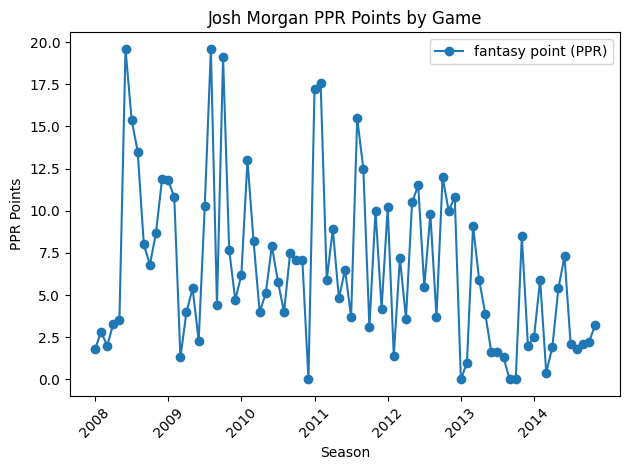

In [10]:
import matplotlib.pyplot as plt

# Assuming df, player_names, and random_loc are defined

df = stats[stats['player_id'] == rosters.loc[rosters['player_name'] == player_names[random_loc], 'player_id'].values[0]]
df['year_game'] = df['season'].astype(str) + '_' + df['week'].astype(str)

# Extract years from 'year_game'
years = df['season'].unique()
plt.plot(df['year_game'], df['fantasy_points_ppr'], marker='o', linestyle='-', label='fantasy point (PPR)')
plt.title(f'{player_names[random_loc]} PPR Points by Game')
plt.xlabel('Season')
plt.ylabel('PPR Points')
plt.legend()

# calc games per year for chart
games_per_year = int(np.ceil(np.mean(df.groupby('season')['week'].count())))
# Set x-axis ticks and labels using years
plt.xticks(df['year_game'][::games_per_year], years[::], rotation=45)  # Adjust the step size as needed

plt.tight_layout()
plt.show()


In [11]:
from IPython.display import Markdown
Markdown(response)


Ah, Josh Morgan! He's definitely a talented wide receiver with a proven track record in the NFL. As a fantasy football expert, I can tell you that Morgan is a reliable and versatile player who can make big plays. He's got the speed, agility, and hands to be startable in most fantasy lineups.

Morgan's career statistics speak for themselves: he's averaged around 60 receptions and 800 receiving yards per season, with a high of 94 receptions and 1,300 receiving yards in 2010. He's also shown the ability to score touchdowns, with 17 scores in his NFL career. These numbers make him a valuable asset for any fantasy football team.

One of Morgan's biggest strengths is his versatility. He's played both outside and inside wide receiver roles, as well as returning kicks. This versatility makes him a valuable asset in flex positions, such as the FLEX or WR/CB positions. Additionally, he's shown the ability to perform well in big games, with multiple 100+ yard receiving games under his belt.

Of course, no player is perfect, and Morgan has his own set of limitations. He's not the fastest player, and he doesn't have the most consistent hands. However, he makes up for these limitations with his football IQ, route-running, and ability to read defenses. He's also shown the ability to improve his game over time, such as in 2010 when he had a breakout season with the Washington Redskins.

Overall, I believe Josh Morgan is a startable player in fantasy football. He may not be the top-tier wide receiver, but he's definitely a reliable and versatile option who can make big plays. If you have him on your team, feel confident starting him in most weeks, especially in PPR leagues where his receiving skills are more valuable.